Core per‑task metrics
    Task creation latency: time from “create task” request to the task being ready to start.
    Scheduling latency: time from “start” request hitting the manager to the moment a proplet receives the assignment.
    Queueing delay: time from scheduling decision to the task actually starting execution on the proplet (captures contention).
    Execution time: time from start on proplet to completion.
    End‑to‑end latency: user “start” request time → result available on GET.
    Result retrieval latency: time to fetch results from the manager.

Scheduler‑specific metrics
    Proplet utilization: fraction of time each worker is busy.
    Load distribution: tasks per proplet, CPU‑time per proplet.
    Carbon signal alignment: fraction of tasks scheduled on lower‑carbon proplets (and how much “carbon cost” you avoided versus a carbon‑agnostic baseline).
    Deadline/SLO compliance: percentage of tasks finishing within a latency budget under different scheduling policies.

Throughput & scalability
    Tasks per second: for different numbers of concurrent clients and proplets.
    Tail latencies: p95 / p99 end‑to‑end latency under load.


# Setup

In [2]:
import json
import requests
import time
import dateutil

import matplotlib.pyplot as plt

In [3]:
def prepare_tasks(task_count, task_name, task_location, task_inputs):
    task_ids = []
    for i in range(task_count):
        # Create task
        resp = requests.post(
            "http://localhost:7070/tasks",
            headers={"Content-Type": "application/json"},
            data=json.dumps({"name": task_name, "inputs": task_inputs}),
        )
        resp.raise_for_status()
        task_id = resp.json()["id"]

        # Upload wasm
        with open(task_location, "rb") as f:
            upload = requests.put(
                f"http://localhost:7070/tasks/{task_id}/upload",
                files={"file": f},
            )
        upload.raise_for_status()
        task_ids.append(task_id)

    return task_ids

In [4]:
def start_tasks(task_ids):
    for task_id in task_ids:
        resp = requests.post(f"http://localhost:7070/tasks/{task_id}/start")
        resp.raise_for_status()

In [5]:
def get_task_results(task_ids):
    results = []
    for task_id in task_ids:
        while True:
            resp = requests.get(f"http://localhost:7070/tasks/{task_id}")
            resp.raise_for_status()
            data = resp.json()
            if "results" in data:
                results.append(data)
                break
            time.sleep(0.01)
    return results

In [6]:
def result_statistics(results):
    # average time, standard deviation, min, max
    times = []
    for result in results:
        start = dateutil.parser.isoparse(result["start_time"])
        finish = dateutil.parser.isoparse(result["finish_time"])
        elapsed_time = (finish - start).total_seconds()
        times.append(elapsed_time)
    mean = sum(times) / len(times)
    variance = sum((x - mean) ** 2 for x in times) / len(times)
    std_dev = variance ** 0.5
    min_time = min(times)
    max_time = max(times)
    return mean, variance, std_dev, min_time, max_time

In [7]:
def execute_test(task_count, task_name, task_location, task_inputs):
    task_ids = prepare_tasks(task_count, task_name, task_location, task_inputs)
    print("Prepared all tasks successfully")
    
    start_tasks(task_ids)
    print("Started all tasks successfully")
    
    results = get_task_results(task_ids)
    mean, variance, std_dev, min_time, max_time = result_statistics(results)
    print(f"Mean time: {mean} seconds")
    print(f"Variance: {variance} seconds")
    print(f"Standard deviation: {std_dev} seconds")
    print(f"Min time: {min_time} seconds")
    print(f"Max time: {max_time} seconds")
    
    return mean, variance, std_dev, min_time, max_time

# Benchmarks

Prepared all tasks successfully
Started all tasks successfully
Mean time: 1.650514 seconds
Variance: 0.0 seconds
Standard deviation: 0.0 seconds
Min time: 1.650514 seconds
Max time: 1.650514 seconds
Prepared all tasks successfully
Started all tasks successfully
Mean time: 3.2526219000000003 seconds
Variance: 0.08726563406409 seconds
Standard deviation: 0.2954075727940806 seconds
Min time: 2.865123 seconds
Max time: 3.632566 seconds
Prepared all tasks successfully
Started all tasks successfully
Mean time: 8.30269826 seconds
Variance: 10.536537218749537 seconds
Standard deviation: 3.2460032684440625 seconds
Min time: 3.232872 seconds
Max time: 16.500304 seconds


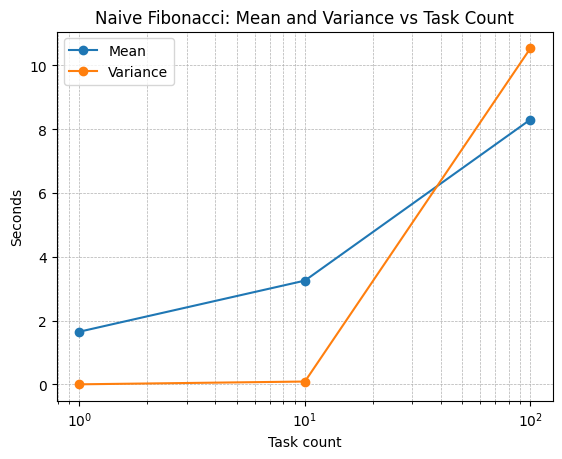

In [9]:
# Addition

task_counts = [1, 10, 100]
means = []
variances = []

for count in task_counts:
    mean, variance, std_dev, min_time, max_time = execute_test(
        task_count=count,
        task_name="naive_fib",
        task_location="build/naive-fib.wasm",
        task_inputs=[40],
    )
    means.append(mean)
    variances.append(variance)

plt.plot(task_counts, means, marker="o", label="Mean")
plt.plot(task_counts, variances, marker="o", label="Variance")
plt.xscale("log")
plt.xlabel("Task count")
plt.ylabel("Seconds")
plt.title("Naive Fibonacci: Mean and Variance vs Task Count")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


# Naive Fibonacci

# Matrix Multiplication


Prepared all tasks successfully
Started all tasks successfully
Mean time: 0.883616 seconds
Variance: 0.0 seconds
Standard deviation: 0.0 seconds
Min time: 0.883616 seconds
Max time: 0.883616 seconds
Prepared all tasks successfully
Started all tasks successfully
Mean time: 1.3569433000000002 seconds
Variance: 0.028305908771810006 seconds
Standard deviation: 0.1682435994973063 seconds
Min time: 1.149908 seconds
Max time: 1.586817 seconds
Prepared all tasks successfully
Started all tasks successfully
Mean time: 3.4088120199999996 seconds
Variance: 0.84441190399348 seconds
Standard deviation: 0.9189188778088521 seconds
Min time: 1.302995 seconds
Max time: 5.309884 seconds


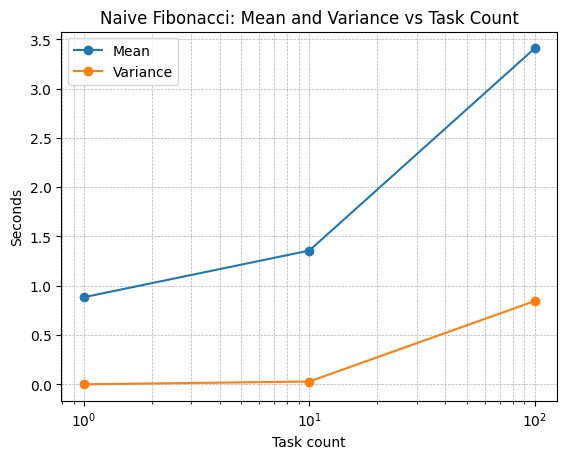

In [8]:
# Addition

task_counts = [1, 10, 100]
means = []
variances = []

for count in task_counts:
    mean, variance, std_dev, min_time, max_time = execute_test(
        task_count=count,
        task_name="naive_fib",
        task_location="build/naive-fib.wasm",
        task_inputs=[40],
    )
    means.append(mean)
    variances.append(variance)

plt.plot(task_counts, means, marker="o", label="Mean")
plt.plot(task_counts, variances, marker="o", label="Variance")
plt.xscale("log")
plt.xlabel("Task count")
plt.ylabel("Seconds")
plt.title("Naive Fibonacci: Mean and Variance vs Task Count")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


# Naive Fibonacci

# Matrix Multiplication
